In [6]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

import librosa
import librosa.display

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

def plotGeneratedImages(epoch, examples=1, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(300, 50)
    librosa.display.specshow(generatedImages, y_axis='linear');
    plt.axis('off')
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    epochs = epochs
    batchCount = int(x_train.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(0, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batchCount)):
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = x_train[np.random.randint(0, x_train.shape[0], size=batchSize)]

            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            yDis = np.zeros(2*batchSize)
            yDis[:batchSize] = 0.9

            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
        dLosses.append(dloss)
        gLosses.append(gloss)
        if e == 1 or e % 50 == 0:
            plotGeneratedImages(e)
            saveModels(e)
    # Plot losses from every epoch
    plotLoss(e)

In [7]:
import glob
rows=300
cols=50
randomDim = 100

import random
from keras.utils import np_utils
x_list = []
y_list = []
filename_npy = glob.glob(r'en_stft_npy/*.npy')
random.shuffle(filename_npy)

for i in range(len(filename_npy)):
    ## 砍掉上半
    x_tmp = np.load(filename_npy[i])[:rows,:]
    x_list.append(x_tmp)
    # mac
    # y_list.append(filename_npy[i].split('/')[1][0])
    # window
    y_list.append(filename_npy[i].split('\\')[1][0])

In [8]:
div = 2500
x_train = np.asarray(x_list[:div])
y_train = np.asarray(y_list[:div])
x_test = np.asarray(x_list[div:])
y_test = np.asarray(y_list[div:])

x_train = x_train.reshape(-1,rows*cols)
x_test = x_test.reshape(-1,rows*cols)

# normalized和1-hot
x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [9]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(rows*cols, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=rows*cols, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

In [10]:
train(1000, 128)

Epochs: 1000
Batch size: 128
Batches per epoch: 19
--------------- Epoch 0 ---------------


100%|██████████████████████████████████████████| 19/19 [00:03<00:00,  5.60it/s]


--------------- Epoch 1 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 2 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.41it/s]


--------------- Epoch 3 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.62it/s]


--------------- Epoch 4 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 5 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.60it/s]


--------------- Epoch 6 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.60it/s]


--------------- Epoch 7 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 8 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


--------------- Epoch 9 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.68it/s]


--------------- Epoch 10 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.67it/s]


--------------- Epoch 11 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.61it/s]


--------------- Epoch 12 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.60it/s]


--------------- Epoch 13 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 14 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


--------------- Epoch 15 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 16 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 17 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.61it/s]


--------------- Epoch 18 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.64it/s]


--------------- Epoch 19 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.62it/s]


--------------- Epoch 20 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 21 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


--------------- Epoch 22 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 23 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 24 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 25 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 26 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 27 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.64it/s]


--------------- Epoch 28 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 29 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 30 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 31 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 32 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.60it/s]


--------------- Epoch 33 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 34 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.62it/s]


--------------- Epoch 35 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.61it/s]


--------------- Epoch 36 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 37 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.63it/s]


--------------- Epoch 38 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 39 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 40 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 41 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 42 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 43 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 44 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 45 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 46 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 47 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 48 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 49 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.67it/s]


--------------- Epoch 50 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.66it/s]


--------------- Epoch 51 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.40it/s]


--------------- Epoch 52 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 53 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 54 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 55 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 56 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


--------------- Epoch 57 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 58 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 59 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 60 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 61 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 62 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 63 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 64 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 65 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 66 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 67 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 68 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 69 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 70 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 71 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 72 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 73 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.61it/s]


--------------- Epoch 74 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 75 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 76 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


--------------- Epoch 77 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 78 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 79 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 80 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 81 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 82 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 83 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 84 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 85 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 86 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.63it/s]


--------------- Epoch 87 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.66it/s]


--------------- Epoch 88 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.65it/s]


--------------- Epoch 89 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


--------------- Epoch 90 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


--------------- Epoch 91 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 92 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 93 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 94 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 95 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 96 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.30it/s]


--------------- Epoch 97 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.38it/s]


--------------- Epoch 98 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.34it/s]


--------------- Epoch 99 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 100 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 101 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.36it/s]


--------------- Epoch 102 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 103 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 104 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 105 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 106 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 107 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 108 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 109 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 110 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 111 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 112 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 113 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 114 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 115 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 116 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 117 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 118 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 119 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.25it/s]


--------------- Epoch 120 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.35it/s]


--------------- Epoch 121 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 122 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 123 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.63it/s]


--------------- Epoch 124 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 125 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 126 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 127 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 128 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 129 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 130 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 131 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 132 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.36it/s]


--------------- Epoch 133 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.41it/s]


--------------- Epoch 134 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 135 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 136 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.40it/s]


--------------- Epoch 137 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 138 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 139 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 140 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 141 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 142 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 143 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 144 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 145 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 146 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 147 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 148 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 149 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 150 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 151 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.33it/s]


--------------- Epoch 152 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 153 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 154 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 155 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 156 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 157 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 158 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 159 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 160 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 161 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 162 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 163 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 164 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 165 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 166 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 167 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 168 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 169 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 170 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 171 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 172 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 173 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 174 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 175 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 176 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.28it/s]


--------------- Epoch 177 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.40it/s]


--------------- Epoch 178 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 179 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.39it/s]


--------------- Epoch 180 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 181 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.36it/s]


--------------- Epoch 182 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 183 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 184 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 185 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 186 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 187 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 188 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 189 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 190 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 191 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 192 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 193 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.61it/s]


--------------- Epoch 194 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.61it/s]


--------------- Epoch 195 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 196 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 197 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 198 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


--------------- Epoch 199 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 200 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.37it/s]


--------------- Epoch 201 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.39it/s]


--------------- Epoch 202 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 203 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 204 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 205 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 206 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 207 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 208 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 209 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 210 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 211 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 212 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 213 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 214 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 215 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 216 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 217 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 218 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 219 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 220 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 221 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 222 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 223 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 224 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 225 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 226 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 227 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 228 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 229 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 230 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 231 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 232 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 233 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 234 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 235 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 236 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 237 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 238 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 239 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 240 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 241 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 242 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 243 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 244 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 245 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 246 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 247 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 248 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 249 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 250 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 251 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.38it/s]


--------------- Epoch 252 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 253 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 254 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 255 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 256 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 257 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 258 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 259 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 260 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 261 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 262 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 263 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 264 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 265 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 266 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 267 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 268 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 269 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 270 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 271 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 272 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 273 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 274 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 275 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.61it/s]


--------------- Epoch 276 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 277 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 278 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 279 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 280 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 281 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 282 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 283 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 284 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 285 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 286 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 287 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 288 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 289 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 290 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 291 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 292 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 293 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 294 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 295 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 296 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 297 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 298 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 299 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 300 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 301 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.33it/s]


--------------- Epoch 302 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 303 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 304 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 305 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 306 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 307 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 308 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 309 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 310 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 311 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 312 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 313 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 314 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 315 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 316 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 317 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 318 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 319 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 320 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 321 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 322 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 323 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 324 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 325 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 326 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 327 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 328 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 329 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 330 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 331 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 332 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 333 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 334 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 335 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 336 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 337 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 338 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 339 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 340 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 341 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 342 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 343 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 344 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 345 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 346 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 347 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 348 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 349 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 350 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 351 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.38it/s]


--------------- Epoch 352 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 353 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 354 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 355 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 356 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 357 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 358 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 359 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 360 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 361 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 362 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 363 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 364 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 365 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 366 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 367 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 368 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 369 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 370 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 371 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 372 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 373 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 374 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 375 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 376 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 377 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 378 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 379 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 380 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 381 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 382 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 383 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 384 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 385 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 386 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 387 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.60it/s]


--------------- Epoch 388 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.59it/s]


--------------- Epoch 389 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 390 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 391 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.57it/s]


--------------- Epoch 392 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 393 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 394 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 395 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 396 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 397 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 398 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 399 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 400 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 401 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 402 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 403 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 404 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 405 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 406 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 407 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 408 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 409 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 410 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 411 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 412 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 413 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 414 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 415 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 416 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 417 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 418 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 419 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 420 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 421 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 422 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 423 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 424 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


--------------- Epoch 425 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 426 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 427 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 428 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 429 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 430 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 431 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 432 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 433 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 434 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 435 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 436 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 437 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 438 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 439 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 440 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 441 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 442 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 443 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 444 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 445 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 446 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 447 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 448 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 449 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 450 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 451 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.39it/s]


--------------- Epoch 452 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 453 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 454 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 455 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 456 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 457 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 458 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 459 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 460 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 461 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 462 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.61it/s]


--------------- Epoch 463 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 464 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 465 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 466 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 467 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 468 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 469 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 470 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 471 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 472 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 473 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 474 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 475 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 476 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 477 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 478 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 479 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 480 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 481 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 482 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 483 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 484 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 485 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 486 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 487 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 488 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 489 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 490 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 491 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 492 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 493 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 494 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 495 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 496 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 497 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 498 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 499 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 500 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 501 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 502 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 503 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 504 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 505 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 506 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 507 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 508 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 509 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 510 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 511 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 512 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 513 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 514 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 515 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 516 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 517 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 518 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 519 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 520 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 521 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 522 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 523 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 524 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 525 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 526 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 527 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 528 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 529 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 530 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.53it/s]


--------------- Epoch 531 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 532 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 533 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 534 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 535 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 536 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 537 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 538 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 539 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 540 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 541 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 542 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 543 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 544 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 545 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 546 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 547 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 548 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 549 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 550 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 551 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.39it/s]


--------------- Epoch 552 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 553 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 554 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 555 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 556 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 557 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 558 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 559 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 560 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 561 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 562 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 563 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 564 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 565 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 566 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 567 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 568 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 569 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 570 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 571 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 572 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 573 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 574 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 575 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 576 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 577 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 578 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 579 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 580 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 581 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 582 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 583 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 584 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 585 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 586 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 587 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 588 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 589 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 590 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 591 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 592 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 593 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 594 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 595 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 596 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 597 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 598 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 599 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 600 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 601 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.38it/s]


--------------- Epoch 602 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 603 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 604 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 605 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 606 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 607 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 608 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 609 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 610 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 611 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 612 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 613 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 614 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 615 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 616 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 617 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 618 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 619 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 620 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 621 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 622 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 623 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 624 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 625 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 626 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 627 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 628 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 629 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 630 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 631 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 632 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 633 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 634 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 635 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 636 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 637 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 638 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 639 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 640 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 641 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 642 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.42it/s]


--------------- Epoch 643 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 644 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 645 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 646 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 647 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 648 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 649 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 650 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.37it/s]


--------------- Epoch 651 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 652 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 653 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 654 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 655 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 656 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 657 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 658 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 659 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 660 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 661 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 662 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 663 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 664 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 665 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 666 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 667 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 668 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 669 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 670 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 671 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 672 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 673 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 674 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 675 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.24it/s]


--------------- Epoch 676 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.28it/s]


--------------- Epoch 677 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.24it/s]


--------------- Epoch 678 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.40it/s]


--------------- Epoch 679 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 680 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 681 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 682 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 683 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 684 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 685 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 686 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 687 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 688 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 689 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 690 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 691 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 692 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 693 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 694 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 695 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 696 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 697 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 698 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 699 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 700 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 701 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.38it/s]


--------------- Epoch 702 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 703 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 704 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 705 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 706 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 707 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 708 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 709 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 710 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 711 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 712 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 713 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 714 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 715 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 716 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 717 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 718 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 719 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 720 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 721 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 722 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 723 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 724 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 725 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 726 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


--------------- Epoch 727 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 728 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 729 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 730 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 731 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 732 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 733 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 734 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 735 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 736 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 737 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 738 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 739 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 740 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 741 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 742 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 743 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 744 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 745 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 746 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 747 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 748 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 749 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 750 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 751 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.32it/s]


--------------- Epoch 752 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 753 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 754 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 755 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 756 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 757 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 758 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 759 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 760 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 761 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 762 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 763 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 764 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 765 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.40it/s]


--------------- Epoch 766 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 767 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 768 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 769 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 770 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 771 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 772 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 773 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 774 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 775 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 776 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 777 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 778 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 779 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 780 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 781 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 782 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 783 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 784 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 785 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 786 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 787 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 788 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 789 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 790 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 791 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 792 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 793 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 794 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 795 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 796 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 797 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 798 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 799 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 800 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 801 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.41it/s]


--------------- Epoch 802 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 803 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 804 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 805 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 806 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 807 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 808 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 809 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 810 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 811 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 812 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 813 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 814 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 815 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 816 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 817 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 818 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 819 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 820 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 821 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 822 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 823 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 824 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 825 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 826 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 827 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 828 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 829 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 830 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 831 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 832 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 833 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 834 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 835 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 836 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 837 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.52it/s]


--------------- Epoch 838 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 839 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 840 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 841 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 842 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 843 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 844 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 845 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 846 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 847 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 848 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 849 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 850 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 851 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.34it/s]


--------------- Epoch 852 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 853 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 854 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.40it/s]


--------------- Epoch 855 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 856 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 857 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 858 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 859 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 860 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 861 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 862 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 863 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 864 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 865 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 866 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 867 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 868 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 869 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 870 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 871 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 872 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 873 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 874 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 875 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 876 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.56it/s]


--------------- Epoch 877 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 878 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 879 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 880 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 881 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 882 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 883 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 884 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 885 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 886 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 887 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 888 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 889 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 890 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 891 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 892 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 893 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 894 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 895 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 896 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 897 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 898 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 899 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 900 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 901 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.36it/s]


--------------- Epoch 902 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 903 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 904 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 905 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 906 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 907 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 908 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 909 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 910 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 911 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 912 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 913 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 914 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 915 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 916 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 917 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 918 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 919 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 920 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 921 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 922 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 923 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 924 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.41it/s]


--------------- Epoch 925 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 926 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 927 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 928 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 929 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 930 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 931 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.42it/s]


--------------- Epoch 932 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 933 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 934 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 935 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 936 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 937 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 938 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.37it/s]


--------------- Epoch 939 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 940 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 941 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 942 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 943 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 944 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 945 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 946 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 947 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 948 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 949 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 950 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 951 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.39it/s]


--------------- Epoch 952 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 953 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 954 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 955 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 956 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 957 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 958 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 959 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 960 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 961 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 962 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 963 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 964 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 965 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 966 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.42it/s]


--------------- Epoch 967 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 968 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 969 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 970 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


--------------- Epoch 971 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 972 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 973 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 974 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 975 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 976 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 977 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 978 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 979 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 980 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 981 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 982 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 983 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 984 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 985 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.44it/s]


--------------- Epoch 986 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 987 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.50it/s]


--------------- Epoch 988 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.51it/s]


--------------- Epoch 989 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.54it/s]


--------------- Epoch 990 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 991 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 992 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 993 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


--------------- Epoch 994 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.43it/s]


--------------- Epoch 995 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 996 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


--------------- Epoch 997 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 998 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.46it/s]


--------------- Epoch 999 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.45it/s]


--------------- Epoch 1000 ---------------


100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 11.34it/s]


In [11]:
noise = np.random.normal(0, 1, size=[1, randomDim])
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(300, 50)

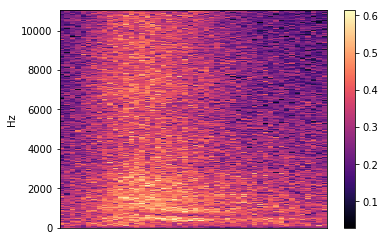

In [14]:
noise = np.random.normal(0, 1, size=[1, randomDim])
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(300, 50)
librosa.display.specshow(generatedImages, y_axis='linear')
plt.colorbar()
plt.show()

In [15]:
out = np.zeros((1250,50))

In [16]:
out[:300,:] = generatedImages

In [17]:
librosa.output.write_wav('generate.wav', librosa.istft(librosa.db_to_amplitude(out)),sr=22050, norm=True)